<a href="https://colab.research.google.com/github/gibranfp/CursoAprendizajeAutomatizado/blob/2023-2/notebooks/1a_clasificador_bayesiano_bernoulli.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Clasificador bayesiano ingenuo de Bernoulli
En esta libreta programaremos un clasificador bayesiano ingenuo en el cual se presupone que la distribución de los atributos dada la clase es una Bernoulli y hay dos posibles clases.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.naive_bayes import BernoulliNB as SKBNB
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer

## Carga de datos

El conjunto de entrenamiento consiste de 11 documentos que pertenecen a las clases de deportes (0) o informática (1). Cada documento es un vector de 8 dimensiones donde cada dimensión representa la frecuencia de las palabras en nuestro vocabulario de interés:

$$
V = \begin{vmatrix}
p_{1} = \textrm{gol}\\
p_{2} = \textrm{maestro}\\
p_{3} = \textrm{velocidad}\\
p_{4} = \textrm{defensa}\\
p_{5} = \textrm{rendimiento}\\
p_{6} = \textrm{campo}\\
p_{7} = \textrm{movimiento}\\
p_{8} = \textrm{ataque}
\end{vmatrix}  
$$

 Lectura con Pandas:

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/gibranfp/CursoAprendizajeAutomatizado/master/data/dep_inf.csv')
df

,p1,p2,p3,p4,p5,p6,p7,p8,c
0,1,0,1,0,1,1,0,1,0
1,1,0,1,0,0,1,0,0,0
2,0,0,1,0,1,1,0,1,0
3,0,0,0,1,1,0,1,1,0
4,1,1,0,0,0,1,0,1,0
5,0,0,1,1,1,1,0,0,0
6,0,1,0,1,0,0,1,0,1
7,1,0,0,1,1,0,1,1,1
8,0,1,0,1,0,1,1,0,1
9,0,0,0,1,0,0,1,1,1


Conversion a numpy:

In [3]:
data = df.to_numpy()

X_ent = data[:, :-1]
y_ent = data[:, -1]

X_nuevos = np.array([[0, 0, 0 , 1, 1, 1, 1, 1], [0, 1, 0, 1, 1, 0, 0, 1]])

## Clasificador bayesiano ingenuo para distribución de Bernoulli
Definimos una función para obtener la probabilidad de 0 o 1 dada una distribución de Bernoulli con parámetro $q$.

In [4]:
def bernoulli(x, q):
  """
  Distribución de bernoulli
  """
  return q**x * (1.0 - q)**(1.0 - x)

Definimos una clase con el clasificador bayesiano ingenuo para atributos binarios y estimación de parámetros por máxima verosimilitud.

In [5]:
bernoulli(np.array([[0, 1, 1], [1,0,0]]), np.array([0.2, 0.3, 0.4]))

array([[0.8, 0.3, 0.4],
       [0.2, 0.7, 0.6]])

In [6]:
class BernoulliNB:
  def fit(self, X, y):
    """
    Estima parámetros por máxima verosimilitud
    """
    self.clases = np.unique(y)
    self.n_clases = self.clases.size
    self.n_atr = X.shape[-1]
    n = X.shape[0]

    self.qa = np.zeros((self.n_clases, self.n_atr))
    self.qc = np.zeros((self.n_clases))
    for i,c in enumerate(self.clases):
      Xc = X[y == c]
      nc = Xc.shape[0]

      cuentas = np.count_nonzero(Xc, axis = 0)
      self.qa[i, :] =  cuentas / nc
      self.qc[i] = nc / n

  def predict_proba(self, X):
    """
    Calcula a posteriori (proporcional) de un conjunto de datos
    """
    prop = np.zeros((X.shape[0], self.n_clases))
    for i in range(self.n_clases):
      prop[:, i] = np.prod(bernoulli(X, self.qa[i, :]), axis=1) * self.qc[i]

    return prop

  def predict(self, X):
    """
    Predice clases de conjunto de datos
    """
    return np.argmax(self.predict_proba(X), axis=1)

bnb = BernoulliNB()
bnb.fit(X_ent, y_ent)

y_bnb = bnb.predict(X_nuevos)
p_bnb = bnb.predict_proba(X_nuevos)

print(y_bnb)
print(p_bnb)

[1 0]
[[0.0015588  0.00279273]
 [0.00031176 0.        ]]


El método `predict_proba` calcula la proporcional de la probabilidad a posteriori

$$
P(\mathbf{x} \vert y)\cdot P(y) \propto P(y \vert \mathbf{x})
$$

Para obtener la probabilidad a posteriori es necesario dividir este valor entre
$$
P(\mathbf{x}) = \sum_c P(\mathbf{x}, y = c) = \sum_c P(\mathbf{x} \vert y = c) P(y = c)
$$

In [7]:
proba_bnb = (p_bnb.T / p_bnb.sum(axis = 1)).T
print(f'Probabilidad a posteriori = {proba_bnb}')

Probabilidad a posteriori = [[0.35821874 0.64178126]
 [1.         0.        ]]


Cuando el número de atributos es muy grande, es conveniente usar escala logarítmica para calcular la proporcional de la probabilidad de cada clase dado un nuevo dato (método `predict_proba`).

In [8]:
class BernoulliNBLog:
  def fit(self, X, y):
    """
    Estima parámetros por máxima verosimilitud
    """
    self.clases = np.unique(y)
    self.n_clases = self.clases.size
    self.n_atr = X.shape[-1]
    n = X.shape[0]

    self.qa = np.zeros((self.n_clases, self.n_atr))
    self.qc = np.zeros((self.n_clases))
    for i,c in enumerate(self.clases):
      Xc = X[y == c]
      nc = Xc.shape[0]

      cuentas = np.count_nonzero(Xc, axis = 0)
      self.qa[i, :] = cuentas / nc
      self.qc[i] = nc / n

    # Para evitar logarítmos de zero en cálculo
    # de a posteriori
    self.qa[self.qa == 0] = np.nextafter(0, 1)
    self.qa[self.qa == 1] = np.nextafter(1, 0)

  def predict_proba(self, X):
    """
    Calcula a posteriori (proporcional) de un conjunto de datos
    """
    prop = np.zeros((X.shape[0], self.n_clases))
    for i in range(self.n_clases):
      a0log = (1 - X) @ np.log(1 - self.qa[i, :])
      a1log = X @ np.log(self.qa[i, :])
      prop[:, i] = a0log + a1log + np.log(self.qc[i])

    return prop

  def predict(self, X):
    """
    Predice clase de conjunto de datos
    """
    return np.argmax(self.predict_proba(X), axis=1)

bnbl = BernoulliNBLog()
bnbl.fit(X_ent, y_ent)

y_bnbl = bnbl.predict(X_nuevos)
p_bnbl = bnbl.predict_proba(X_nuevos)

print(y_bnb)
print(p_bnbl) # Proporcional de probabilidades logarítmicas
print(np.exp(p_bnbl)) # Proporcional de probabilidades
print((np.exp(p_bnbl).T / np.exp(p_bnbl).sum(axis = 1)).T) # Probabilidades

[1 0]
[[ -6.46384036  -5.88073664]
 [ -8.07327827 -40.82577774]]
[[1.55879786e-03 2.79272727e-03]
 [3.11759571e-04 1.86033007e-18]]
[[3.58218742e-01 6.41781258e-01]
 [1.00000000e+00 5.96719474e-15]]


Nota que no es necesario modificar la estimación de parámetros (método `fit`).

Para estimar parámetros por máximo a posteriori, solo se necesita cambiar el método `fit` de la siguiente manera.

In [9]:
class BernoulliNBLogMAP:
  def fit(self, X, y, alfa=2):
    """
    Estima parámetros por máximo a posteriori
    """
    self.clases = np.unique(y)
    self.n_clases = self.clases.size
    self.n_atr = X.shape[-1]
    n = X.shape[0]

    self.qa = np.zeros((self.n_clases, self.n_atr))
    self.qc = np.zeros((self.n_clases))
    for i,c in enumerate(self.clases):
      Xc = X[y == c]
      nc = Xc.shape[0]

      # Asignamos misma alfa para todas las categorías
      self.qc[i] = (nc + alfa - 1) / (n + alfa * self.n_clases - self.n_clases)
      cuentas = np.count_nonzero(Xc, axis = 0)
      self.qa[i, :] = (cuentas + alfa - 1) / (nc + self.n_atr + alfa - 2)

  def predict_proba(self, X):
    """
    Calcula a posteriori (proporcional) de un conjunto de datos
    """
    prop = np.zeros((X.shape[0], self.n_clases))
    for i in range(self.n_clases):
      a0log = (1 - X) @ np.log(1 - self.qa[i, :])
      a1log = X @ np.log(self.qa[i, :])
      prop[:, i] = a0log + a1log + np.log(self.qc[i])

    return prop

  def predict(self, x):
    """
    Predice clases de un conjunto de datos
    """
    return np.argmax(self.predict_proba(x), axis=1)

bnblm = BernoulliNBLogMAP()
bnblm.fit(X_ent, y_ent)

y_bnblm = bnblm.predict(X_nuevos)
p_bnblm = bnblm.predict_proba(X_nuevos)

print(y_bnblm)
print(p_bnblm) # Proporcional de probabilidades logarítmicas
print(np.exp(p_bnblm)) # Proporcional de probabilidades
print((np.exp(p_bnblm).T / np.exp(p_bnblm).sum(axis = 1)).T) # Probabilidades

[1 1]
[[-7.94438676 -7.94366196]
 [-7.65670469 -6.89569341]]
[[0.00035465 0.0003549 ]
 [0.00047286 0.00101213]]
[[0.4998188  0.5001812 ]
 [0.31842675 0.68157325]]


## Clasificación de documentos por tema
Probaremos nuestro clasificador bayesiano ingenuo en la clasificación de documentos por tema usando el conjunto de datos _20 newsgroups_.

In [10]:
ng_ent = fetch_20newsgroups(subset='train',
                            shuffle=True,
                            random_state=42)

ng_prueba = fetch_20newsgroups(subset='test',
                               shuffle=True,
                               random_state=42)

Obtenemos la representación vectorizada binaria.

In [11]:
vec = CountVectorizer(max_features=10000,
                      stop_words='english',
                      binary=True)

X_ent = vec.fit_transform(ng_ent.data)
y_ent = ng_ent.target

X_prueba = vec.transform(ng_prueba.data)
y_prueba = ng_prueba.target

Veamos cómo están distribuidas las clases en el conjunto de entrenamiento

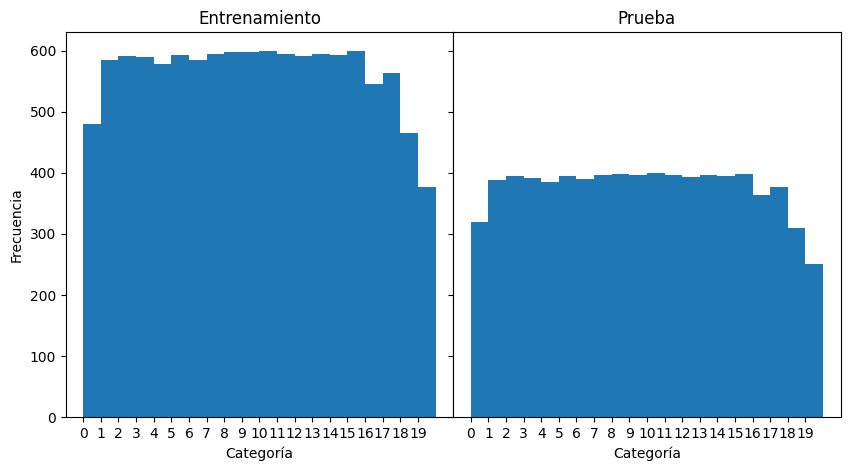

In [12]:
f,axs = plt.subplots(1,2, figsize=(10,5), sharey=True)

axs[0].hist(y_ent, bins=[i for i in range(21)])
axs[0].set_xticks(np.unique(y_ent))
axs[0].set_xlabel(u'Categoría')
axs[0].set_xlabel(u'Categoría')
axs[0].set_ylabel('Frecuencia')
axs[0].set_title(u'Entrenamiento')

axs[1].hist(y_prueba, bins=[i for i in range(21)])
axs[1].set_xticks(np.unique(y_prueba))
axs[1].set_xlabel(u'Categoría')
axs[1].set_title(u'Prueba')

plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

En `scikit-learn` dentro del submódulo `naive_bayes` están definidos clasificadores bayesianos ingenuos con distintas distribuciones para los atributos. Compararemos nuestro clasificador con el `BernoulliNB` de `scikit-learn` para distintos tamaños de vocabulario.

In [13]:
tam = np.arange(2000, 22000, 2000)
exac_nt = []
exac_sk = []
for t in tam:
  vec = CountVectorizer(max_features=t,
                        stop_words='english',
                        binary=True)

  X_ent = vec.fit_transform(ng_ent.data)
  y_ent = ng_ent.target

  X_prueba = vec.transform(ng_prueba.data)
  y_prueba = ng_prueba.target

  clasificador = BernoulliNBLogMAP()
  clasificador.fit(X_ent.toarray(), y_ent)
  pred = clasificador.predict(X_prueba.toarray())
  exactitud = (pred==y_prueba).mean()
  exac_nt.append(exactitud)
  print('Exactitud = {0}'.format(exactitud))

Exactitud = 0.6299787573021773
Exactitud = 0.6763143919277749
Exactitud = 0.7044609665427509
Exactitud = 0.7156133828996283
Exactitud = 0.7259691980881572
Exactitud = 0.733935209771641
Exactitud = 0.7405735528412108
Exactitud = 0.7453531598513011
Exactitud = 0.7480084970791291
Exactitud = 0.7485395645246946


Graficamos el rendimiento con respecto al tamaño del vocabulario.

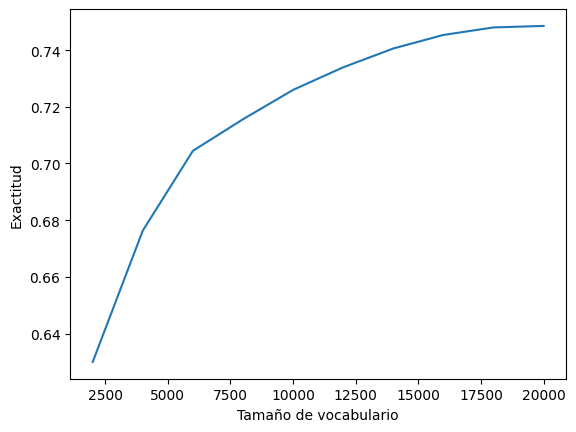

In [14]:
plt.plot(tam, exac_nt)
plt.xlabel(u'Tamaño de vocabulario')
plt.ylabel(u'Exactitud')
plt.show()